### KAGGLE COMPETITION: BACKPACK PREDICTION

#### 1. IMPORTS

In [4]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model  import Ridge
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
# Desabilitar FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#### 2. DATA PREPARATION

##### 2.1. DATA COLLECTION

In [5]:
# Loading datasets
df_train = pd.read_csv("data/train.csv")
df_extra = pd.read_csv("data/training_extra.csv")   
df = pd.concat([df_train, df_extra], axis=0)
df = df.drop(columns='id')
df = df.reset_index(drop=True)
df.head(20)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
7,Puma,Canvas,Small,1.0,Yes,Yes,Backpack,Blue,21.488864,27.15815
8,Under Armour,Polyester,Medium,8.0,Yes,No,Tote,Gray,10.207780,25.98652
9,Under Armour,Nylon,Medium,2.0,Yes,Yes,Messenger,Pink,15.895100,38.48741


##### 2.2. EXPLORATORY DATA ANALYSIS

In [6]:
# Checking dataset length
df.shape

(3994318, 10)

In [7]:
# Checking features' types
df.dtypes

Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

In [8]:
# Checking for missing values
print(df.isna().sum())

Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64


In [9]:
# Investigating Numerical Data
numerical_columns = [col for col in df.select_dtypes(include=['float', 'int']).columns]
df.describe().applymap(lambda x: '{:.2f}'.format(x))

,Compartments,Weight Capacity (kg),Price
count,3994318.00,3992510.00,3994318.00
mean,5.43,18.01,81.36
std,2.89,6.97,38.94
min,1.00,5.00,15.00
25%,3.00,12.07,47.47
50%,5.00,18.05,80.98
75%,8.00,23.99,114.86
max,10.00,30.00,150.00


In [10]:
# Outliers percentual
for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    sup_lim = Q3 + 1.5 * IQR
    percentual = len(df[df[column] > sup_lim]) / len(df)
    print(f"{column}: {percentual}%")

Compartments: 0.0%
Weight Capacity (kg): 0.0%
Price: 0.0%


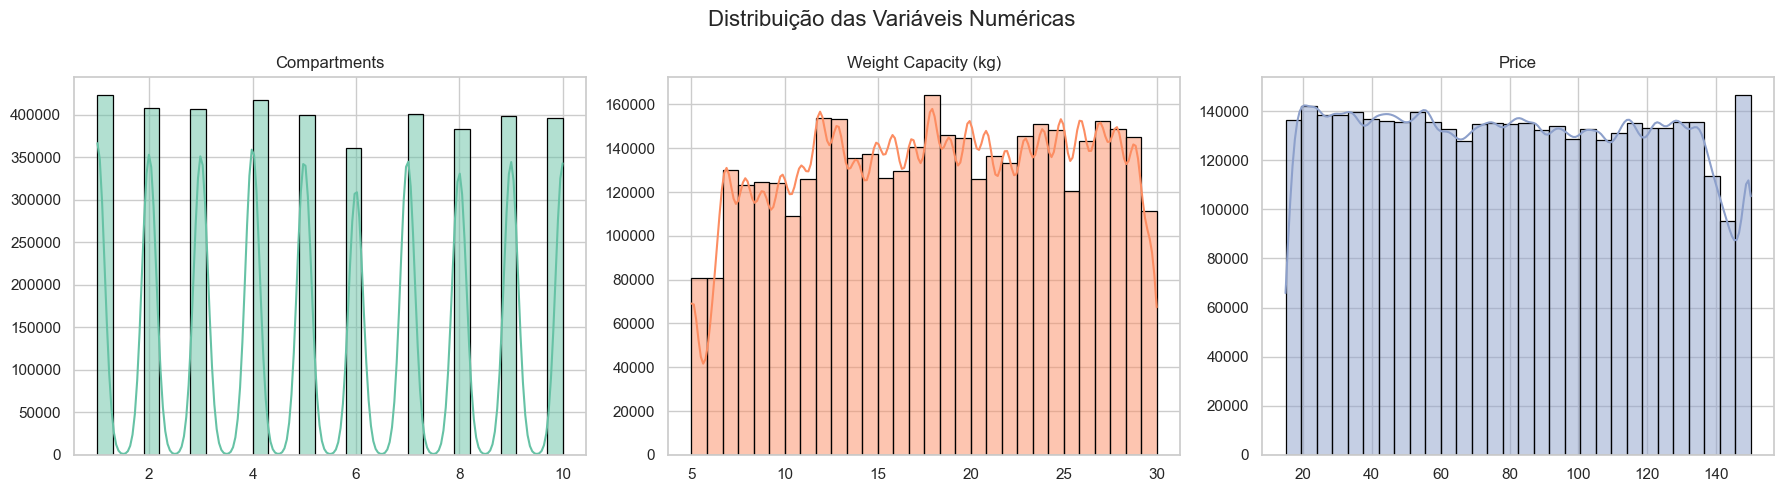

In [11]:
# Histograms of numerical columns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 5))
counter = 1
palette = sns.color_palette("Set2")
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)

for column in numerical_columns:
    plt.subplot(1, 3, counter)
    sns.histplot(df[column], kde=True, bins=30, color=sns.color_palette("Set2")[counter - 1], edgecolor="black")
    plt.title(f'{column}')
    plt.xlabel("")
    plt.ylabel("")
    counter += 1

plt.tight_layout()
plt.savefig("images/numerical_features_distribution.png")
plt.show()

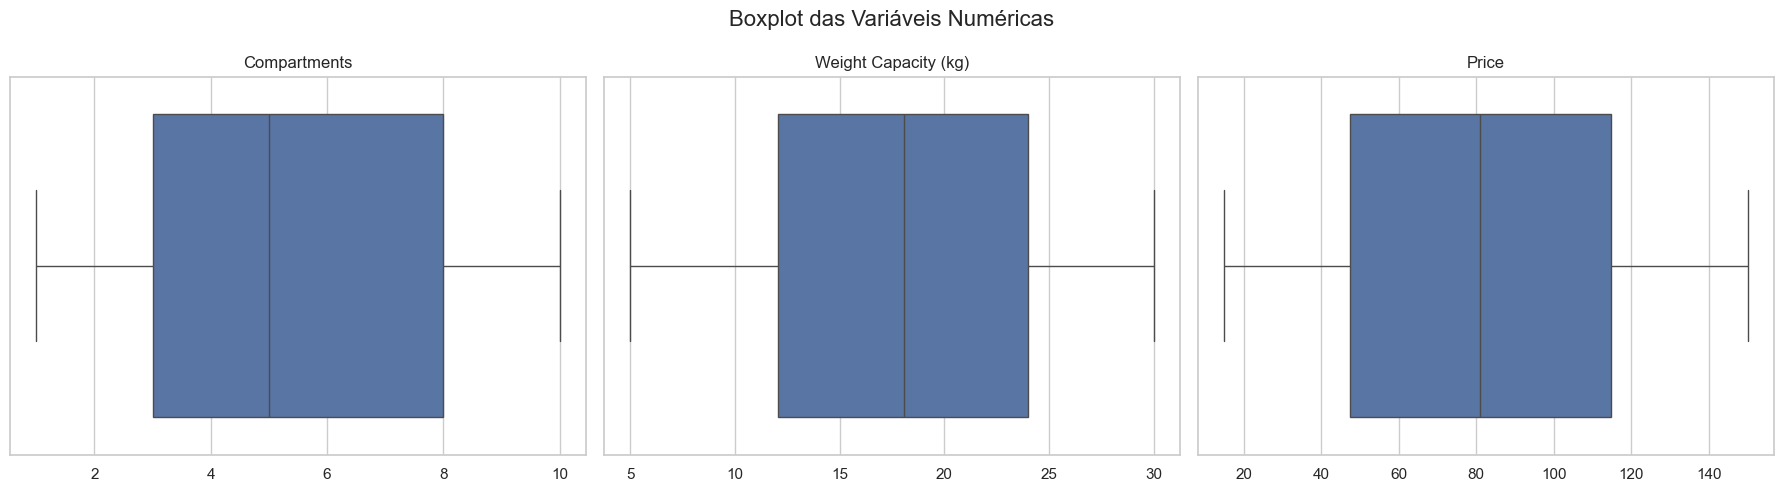

In [12]:
# Boxplots of numerical columns
plt.figure(figsize=(18, 5))
counter = 1
plt.suptitle('Boxplot das Variáveis Numéricas', fontsize=16)

for column in numerical_columns:
    plt.subplot(1, 3, counter)
    sns.boxplot(data=df, x=column, fliersize=5)
    plt.title(f'{column}')
    plt.xlabel("")
    plt.ylabel("")
    counter += 1

plt.tight_layout()
plt.savefig("images/numerical_features_boxplot.png")
plt.show()

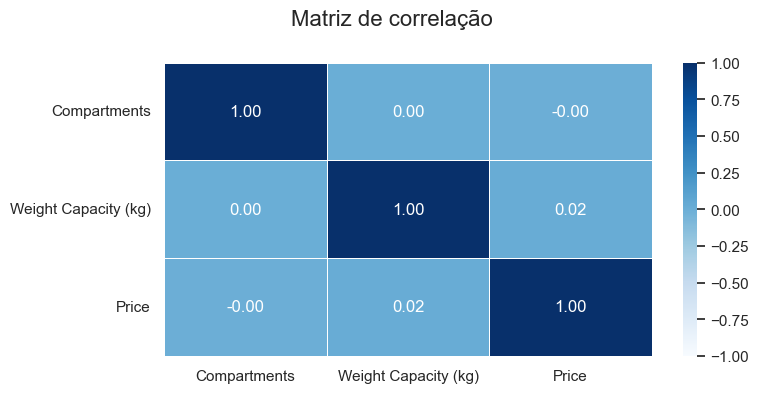

In [13]:
# Correlation matrix
df_numerical = df.select_dtypes(include=['float', 'int'])
correlation = df_numerical.corr()
plt.figure(figsize=(8, 4))
plt.suptitle('Matriz de correlação', fontsize=16)
sns.heatmap(correlation, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

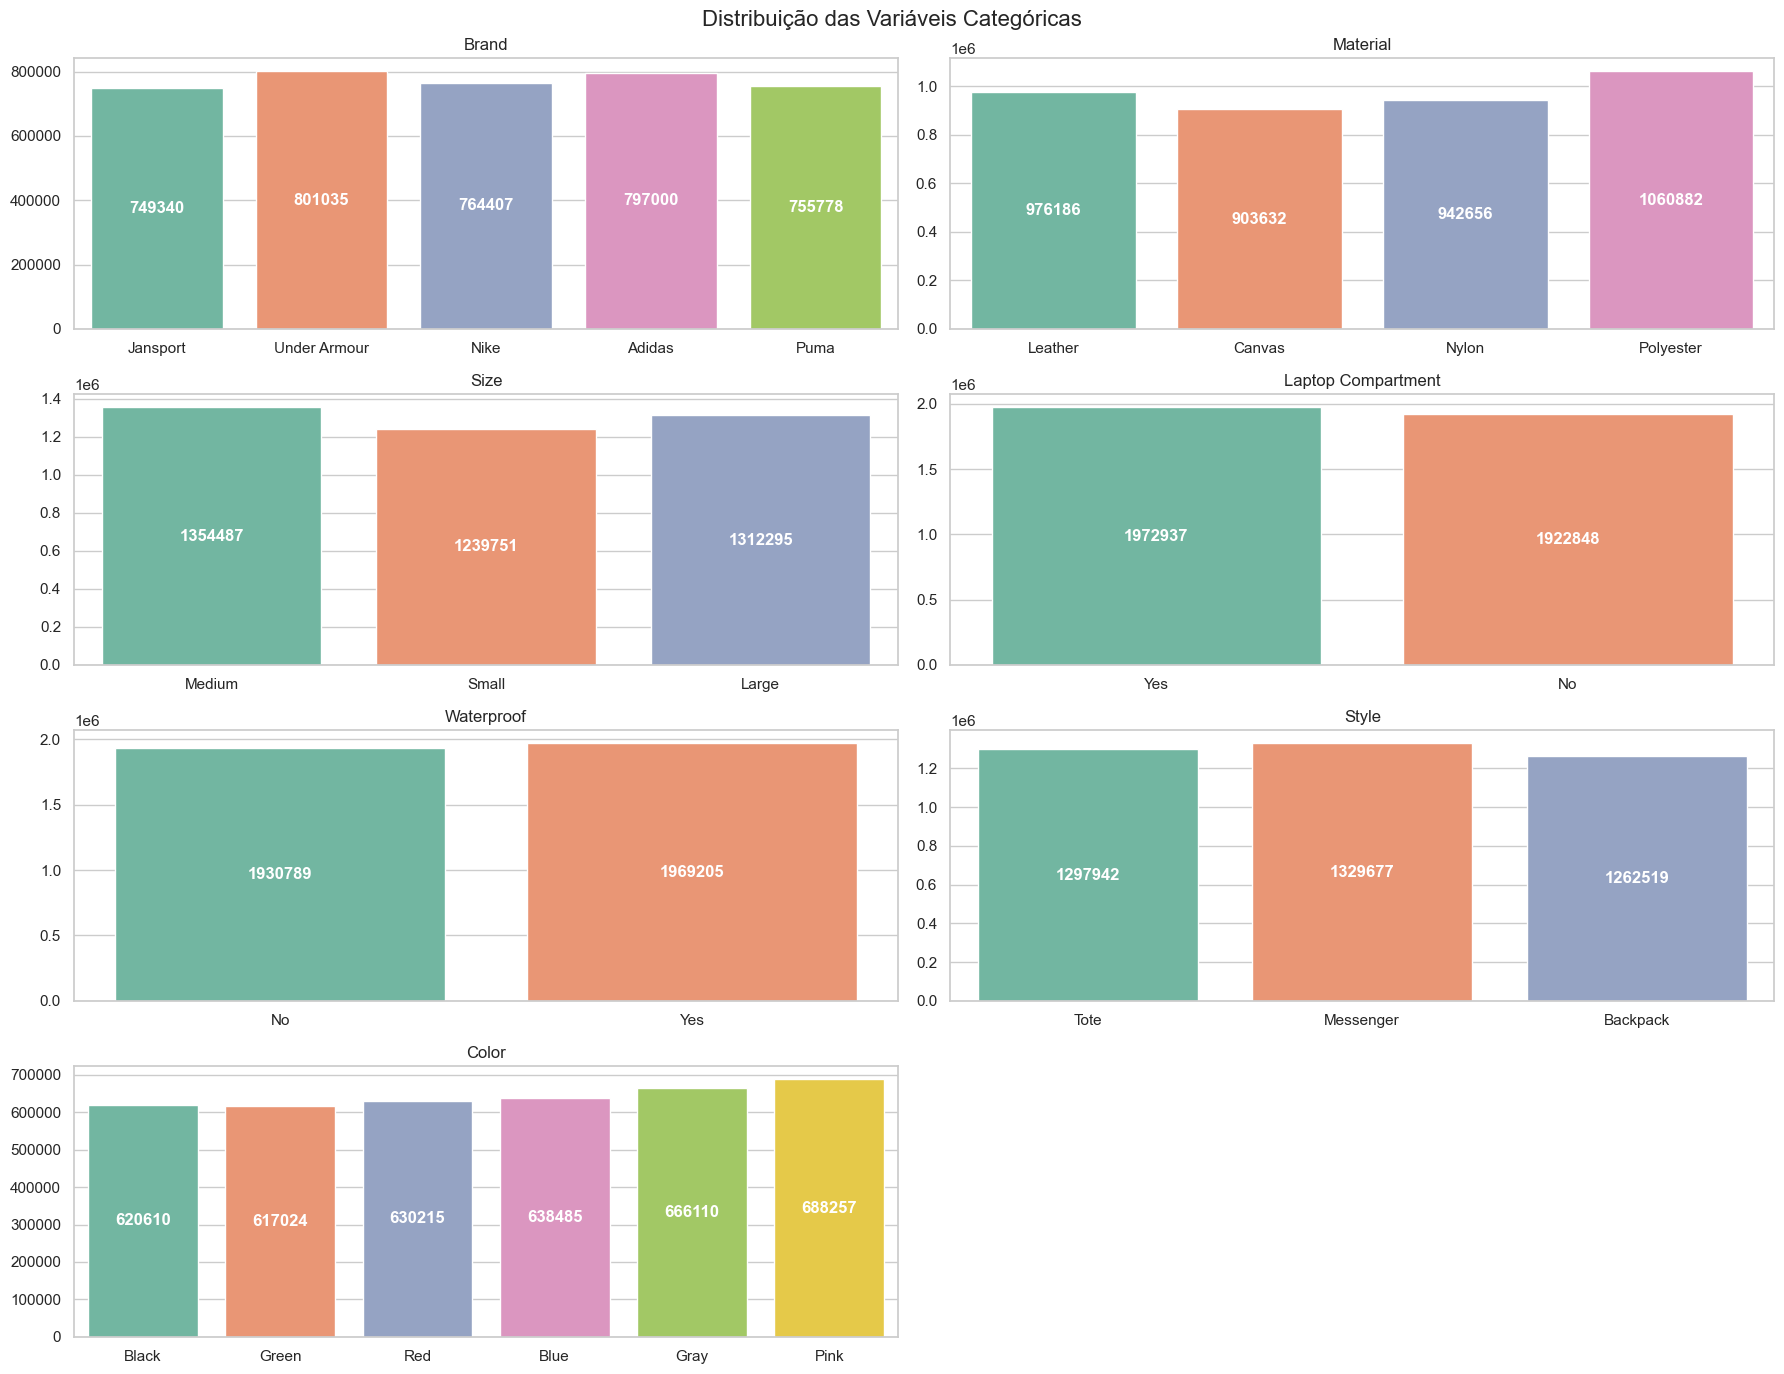

In [14]:
# Investigating categorical columns

# Creating list of categorical columns names
categorical_columns = [col for col in df.select_dtypes(include=['object']).columns 
                       if df[col].nunique() < 50]


plt.figure(figsize=(18, 14))
counter = 1
plt.suptitle('Distribuição das Variáveis Categóricas', fontsize=16)

for column in categorical_columns:
    plt.subplot(4, 2, counter)
    ax = sns.countplot(x=column, data=df, palette='Set2')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2, p.get_height() / 2), 
        ha='center', va='center', 
        fontsize=12, color='white', fontweight='bold')
    plt.title(f'{column}')
    plt.xlabel("")
    plt.ylabel("")
    counter += 1
            
plt.tight_layout()
plt.savefig("images/categorical_features_distribution.png")
plt.show()

In [15]:
# Calculating frequencies' percentuals
for column in categorical_columns:
    print(f"\nRelative frequencies for {column}: ")
    freq_percentage = df[column].value_counts(normalize=True) * 100
    print(freq_percentage)


Relative frequencies for Brand: 
Brand
Under Armour    20.711637
Adidas          20.607308
Nike            19.764580
Puma            19.541468
Jansport        19.375006
Name: proportion, dtype: float64

Relative frequencies for Material: 
Material
Polyester    27.318690
Leather      25.137690
Nylon        24.274262
Canvas       23.269358
Name: proportion, dtype: float64

Relative frequencies for Size: 
Size
Medium    34.672355
Large     33.592318
Small     31.735326
Name: proportion, dtype: float64

Relative frequencies for Laptop Compartment: 
Laptop Compartment
Yes    50.642861
No     49.357139
Name: proportion, dtype: float64

Relative frequencies for Waterproof: 
Waterproof
Yes    50.492514
No     49.507486
Name: proportion, dtype: float64

Relative frequencies for Style: 
Style
Messenger    34.180715
Tote         33.364935
Backpack     32.454350
Name: proportion, dtype: float64

Relative frequencies for Color: 
Color
Pink     17.827255
Gray     17.253602
Blue     16.538059
Red   

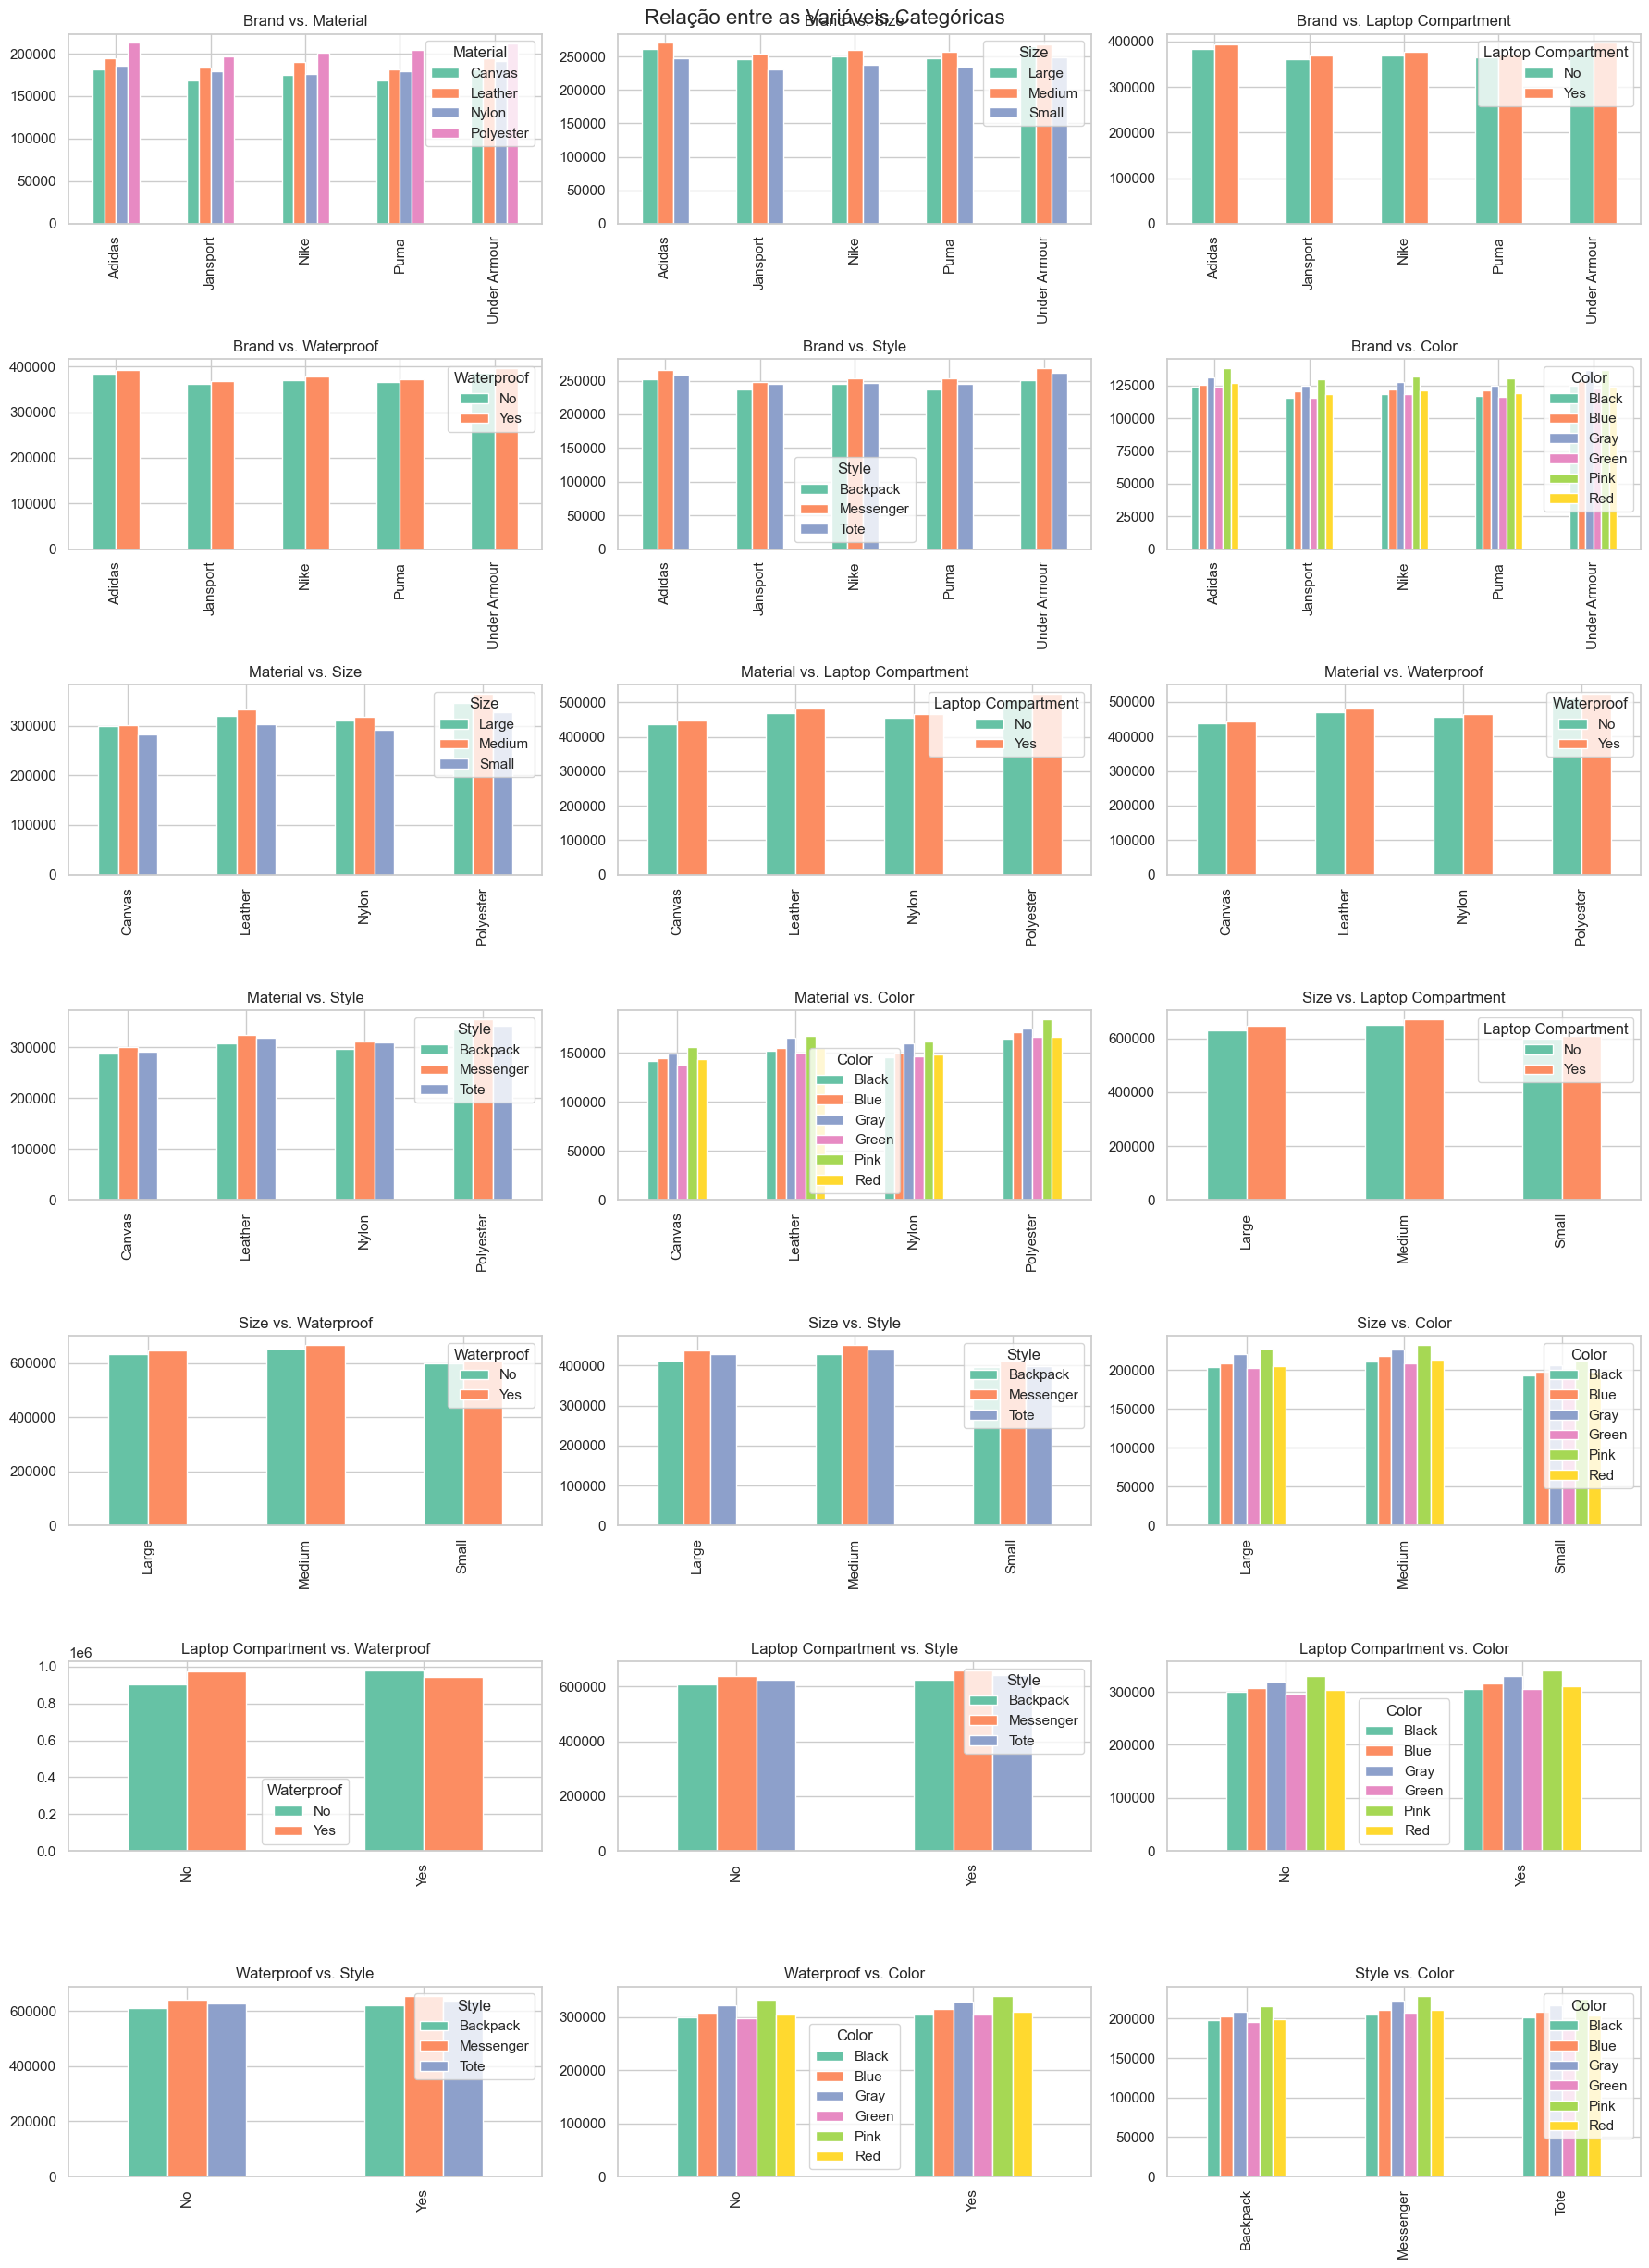

In [16]:
# Categorical features' relations
plt.figure(figsize=(18, 25))
ncols = 3
nrows = math.ceil(math.comb(len(categorical_columns), 2) / ncols)
counter = 1
plt.suptitle('Relação entre as Variáveis Categóricas', fontsize=16)

for i in range(len(categorical_columns) - 1):
    for j in range(i + 1, len(categorical_columns)):
        # Create subplots
        plt.subplot(nrows, ncols, counter)
        
        # Create the contingency table
        crosstab = pd.crosstab(df[categorical_columns[i]], df[categorical_columns[j]])
        
        # Plot the bar chart of the contingency table
        crosstab.plot(kind='bar', stacked=False, ax=plt.gca(), color=sns.color_palette("Set2"))
        
        plt.title(f'{categorical_columns[i]} vs. {categorical_columns[j]}', fontsize=12)
        plt.xlabel("")
        plt.ylabel("")
        counter += 1

plt.tight_layout()
plt.savefig("images/categorical_features_relations.png")
plt.show()

<Axes: xlabel='Price', ylabel='Count'>

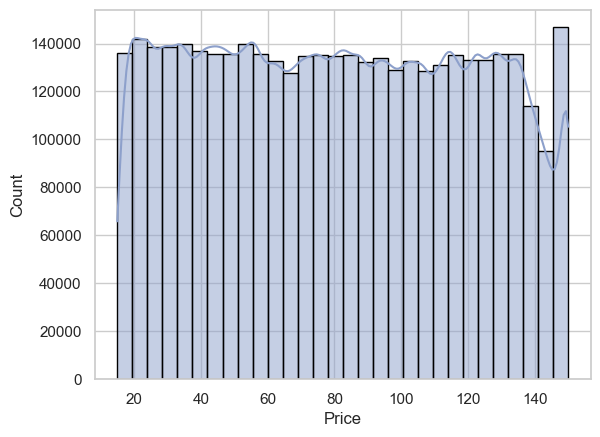

In [17]:
# Investigating target
sns.histplot(df['Price'], kde=True, bins=30, color=sns.color_palette("Set2")[2], edgecolor='black')

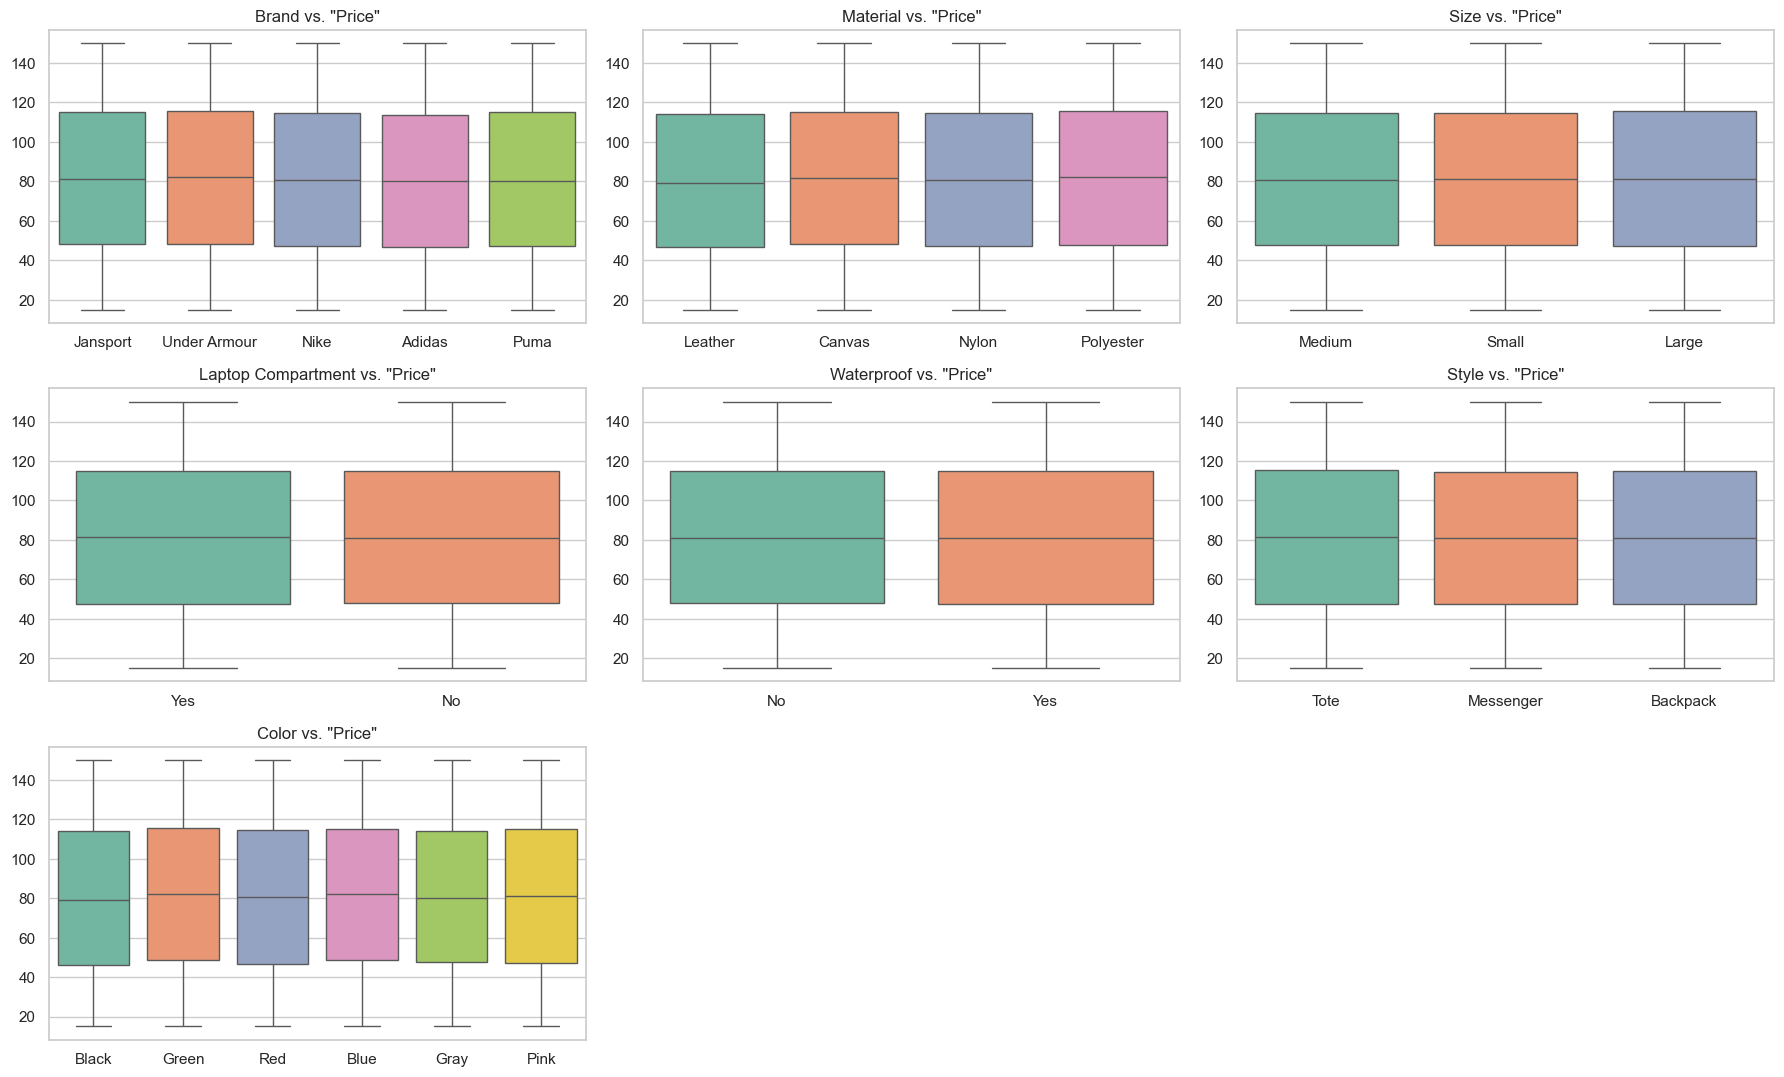

In [18]:
# Target relation with categorical columns
plt.figure(figsize=(18, 25))
ncols = 3
nrows = math.ceil(math.comb(len(categorical_columns), 2) / ncols)
counter = 1

for column in categorical_columns:
    # Create subplots
    plt.subplot(nrows, ncols, counter)
      
    # Boxplot categoical column and target
    sns.boxplot(x=column, y='Price', data=df, palette="Set2")
        
    plt.title(f'{column} vs. "Price"', fontsize=12)
    plt.xlabel("")
    plt.ylabel("")
    counter += 1

plt.tight_layout()
plt.savefig("images/target_categorical_features_relations.png")
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_23964\3449196194.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=column, y='Price', data=df,  palette="Set2")
C:\Users\julia\AppData\Local\Temp\ipykernel_23964\3449196194.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=column, y='Price', data=df,  palette="Set2")


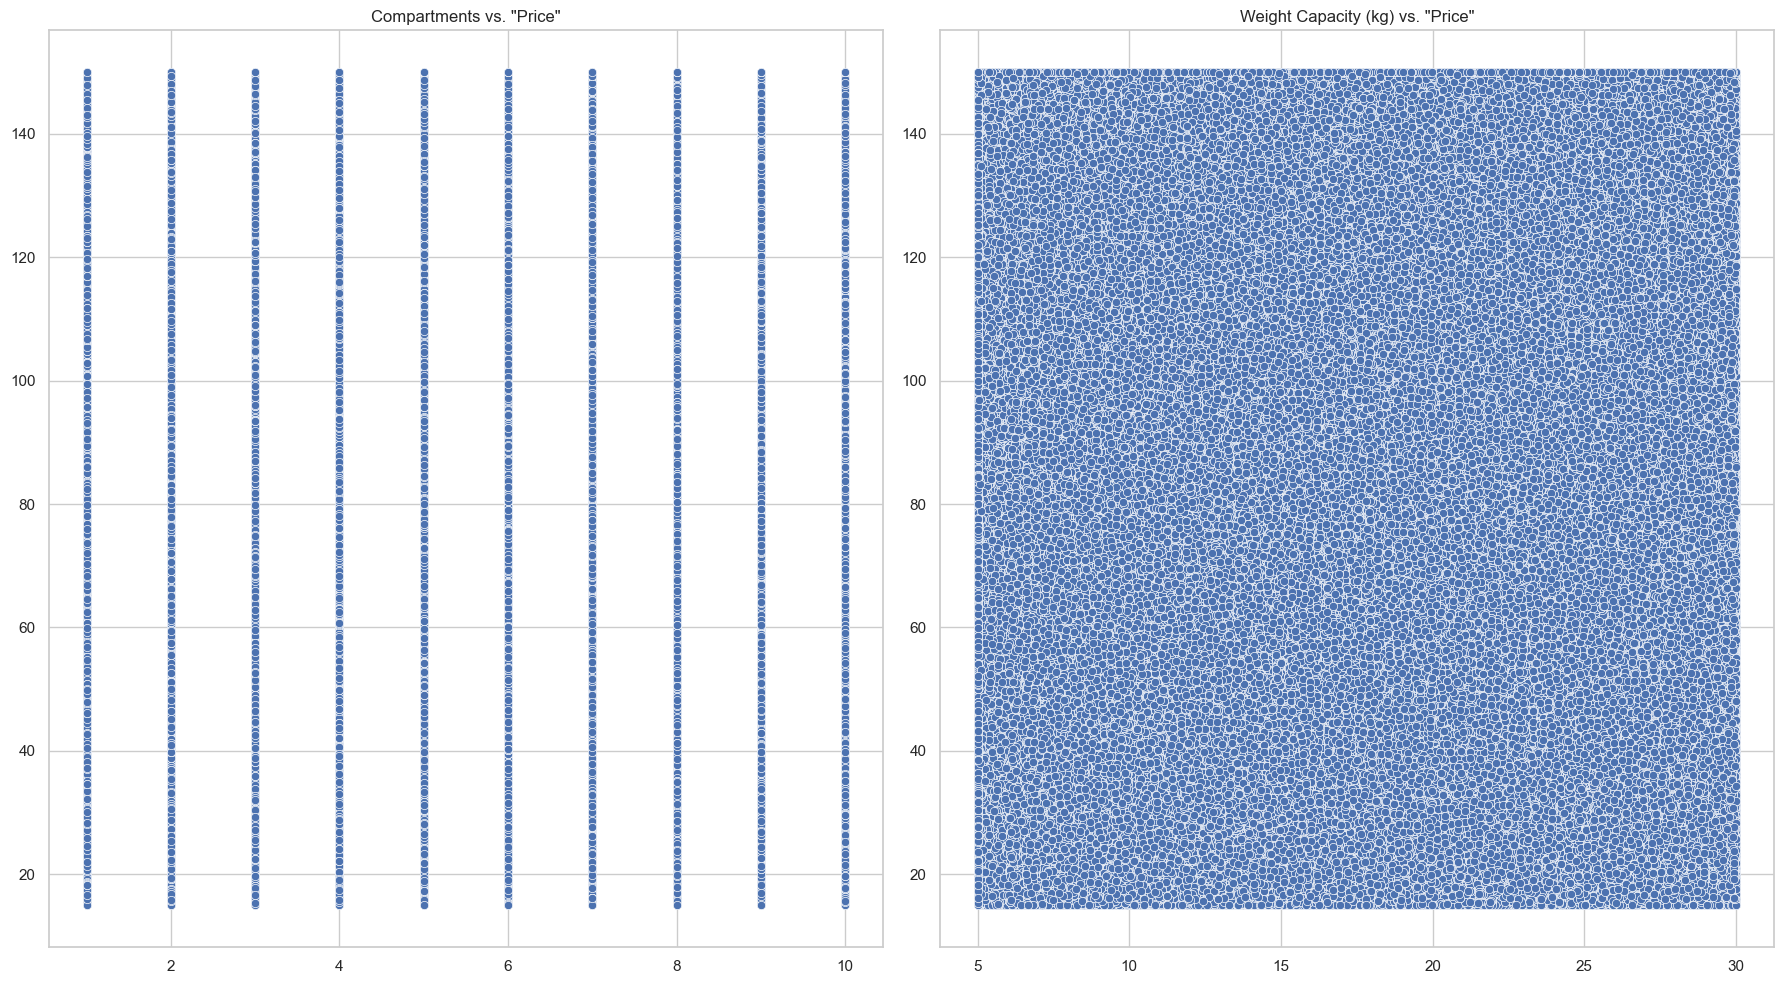

In [19]:
# Target relation with numerical columns
numerical_columns = ['Compartments', 'Weight Capacity (kg)']
plt.figure(figsize=(18, 10))
ncols = 2
nrows = math.ceil(math.comb(len(numerical_columns), 2) / ncols)
counter = 1

for column in numerical_columns:
    # Create subplots
    plt.subplot(nrows, ncols, counter)
      
    # Boxplot categoical column and target
    sns.scatterplot(x=column, y='Price', data=df,  palette="Set2")
        
    plt.title(f'{column} vs. "Price"', fontsize=12)
    plt.xlabel("")
    plt.ylabel("")
    counter += 1

plt.tight_layout()
plt.savefig("images/target_numerical_features_relations.png")
plt.show()

##### 2.3. PRE-PROCESSING

In [20]:
def data_pre_processing(df):
    # Creating a copy of the dataframe to avoid modifying the original dataframe
    df_processed = df.copy()

    # Transforming the 'Compartments' column from numeric to 'object' type (to treat it as a categorical variable)
    df_processed['Compartments'] = df_processed['Compartments'].astype(int).astype(object)

    # Filling NaN values in categorical columns randomly, while maintaining the same category proportions
    cat_columns = df_processed.select_dtypes(include=['object']).columns
    for column in cat_columns:
        # Getting the proportion of each category to maintain the distribution when filling NaN values
        category_percent = df_processed[column].value_counts(normalize=True)
        
        # Filling the NaN values
        n_nan = df_processed[column].isna().sum()
        categories = category_percent.index
        proportions = category_percent.values

        new_values = np.random.choice(categories, size=n_nan, p=proportions)

        df_processed.loc[df_processed[column].isna(), column] = new_values

    # Filling NaN values in 'Weight Capacity (kg)' column with the column's mean
    df_processed['Weight Capacity (kg)'] = df_processed['Weight Capacity (kg)'].fillna(df_processed['Weight Capacity (kg)'].mean())
    
    # Converting the 'Weight Capacity (kg)' column into a categorical column called 'weight_category', dividing into value ranges
    bins = [5, 10, 15, 20, 25, 31]
    labels = ['5-10', '10-15', '15-20', '20-25', '25-30']
    df_processed['weight_category'] = pd.cut(df_processed['Weight Capacity (kg)'], bins=bins, labels=labels, right=False).astype('object')

    # Dropping the 'Weight Capacity (kg)' column after transforming it into 'weight_category'
    df_processed = df_processed.drop(columns='Weight Capacity (kg)')
    
    return df_processed

In [21]:
df_processed = data_pre_processing(df)

##### 2.4. FEATURE ENGINEERING

In [22]:
def feature_engineering(df):
    # Creating a copy of the dataframe to avoid modifying the original dataframe
    df_eng = df.copy()

    # One hot encoding categorical columns
    cat_columns = df_eng.select_dtypes(include=['object']).columns
    for column in cat_columns:
        df_eng = pd.get_dummies(df_eng, columns=[column], dtype=int)
    
    return df_eng

In [23]:
df_eng = feature_engineering(df_processed)

##### 2.5. FEATURE SELECTION

In [24]:
def evaluate_column_relevance(df):
    irrelevant_columns = []
    
    for column in df.columns:
        
        # Check if the column is categorical (numeric type)
        if df[column].dtype == 'int32' or df[column].dtype == 'int64':
            
            if df[column].nunique() == 2:
                # Mann-Whitney U test for binary variables
                group_1 = df[df[column] == df[column].unique()[0]]['Price']
                group_2 = df[df[column] == df[column].unique()[1]]['Price']
                u_stat, p_value = stats.mannwhitneyu(group_1, group_2)
                
                if p_value > 0.05:
                    irrelevant_columns.append(column)

            # If the column has more than 2 categories
            else:
                # Kruskal-Wallis test for multi-class variables
                categories = [df[df[column] == cat]['Price'] for cat in df[column].unique()]
                h_stat, p_value = stats.kruskal(*categories)
                
                if p_value > 0.05:
                    irrelevant_columns.append(column)
            
    # Return the list of irrelevant columns
    return irrelevant_columns

In [25]:
irrelevant_columns = evaluate_column_relevance(df_eng)
print("Colunas sem relevância para o target: ", irrelevant_columns)
df_selected = df_eng.drop(columns=irrelevant_columns)

Colunas sem relevância para o target:  ['Size_Small', 'Laptop Compartment_No', 'Laptop Compartment_Yes', 'Waterproof_No', 'Waterproof_Yes', 'Style_Backpack']


#### 3. MODELLING

##### 3.1. MODEL TRAINING

In [26]:
def evaluate_models(df, target_column, frac=0.1, random_state=42):
    # Take a sample from the dataset
    df_sample = df.sample(frac=frac, random_state=random_state)
    
    # Separate the independent variables and the target
    X = df_sample.drop(columns=[target_column])
    y = df_sample[target_column]
    
    # List of models to be tested
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest Regressor': RandomForestRegressor(random_state=random_state),
        'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=random_state),
        'CatBoost Regressor': CatBoostRegressor(iterations=1000, task_type='CPU', random_seed=random_state, verbose=False),
        'Ridge Regression': Ridge(),
        'ElasticNet Regression': ElasticNet(),
        'XGBoost Regressor': xgb.XGBRegressor(n_estimators=100, random_state=random_state),
        'LightGBM Regressor': lgb.LGBMRegressor(n_estimators=100, random_state=random_state)
    }
    
    # Test the models with Cross-Validation and calculate RMSE
    results = []
    for model_name, model in models.items():
        # Perform Cross-Validation (K-Fold Cross-Validation)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        
        # Convert back to RMSE
        rmse_scores = np.sqrt(-cv_scores)
        
        # Calculate the mean and standard deviation of RMSE
        mean_rmse = np.mean(rmse_scores)
        std_rmse = np.std(rmse_scores)
        
        results.append((model_name, mean_rmse, std_rmse))
    
    return results

In [27]:
results = evaluate_models(df_selected, 'Price')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 319545, number of used features: 34
[LightGBM] [Info] Start training from score 81.471151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 319545, number of used features: 34
[LightGBM] [Info] Start training from score 81.391124
[LightGBM] [Warning] Found w

In [28]:
print(results)

[('Linear Regression', 38.91126246992256, 0.051007980672407964), ('Random Forest Regressor', 42.43472066828523, 0.05708619184525608), ('Gradient Boosting Regressor', 38.91171668417251, 0.05207350090544268), ('CatBoost Regressor', 39.02151562371533, 0.05310432512744125), ('Ridge Regression', 38.911262396176234, 0.05100798881493014), ('ElasticNet Regression', 38.933952113744695, 0.05137000103682482), ('XGBoost Regressor', 39.02170496220974, 0.05262126820977683), ('LightGBM Regressor', 38.92070762068621, 0.053270954955659595)]


##### 3.2. EVALUATION

In [29]:
# Print the average RMSE and standard deviation for each algorithm
print("Average RMSE and Standard Deviation by Algorithm (Cross-Validation):")
for model_name, mean_rmse, std_rmse in results:
    print(f"{model_name}: {mean_rmse:.5f}")

Average RMSE and Standard Deviation by Algorithm (Cross-Validation):
Linear Regression: 38.91126
Random Forest Regressor: 42.43472
Gradient Boosting Regressor: 38.91172
CatBoost Regressor: 39.02152
Ridge Regression: 38.91126
ElasticNet Regression: 38.93395
XGBoost Regressor: 39.02170
LightGBM Regressor: 38.92071


##### 3.3. HYPERPARAMETER TUNING

In [30]:
# Take a sample from the dataset
df_sample = df_selected.sample(frac=0.1, random_state=42)
    
# Separate the independent variables and the target
X = df_sample.drop(columns=['Price'])
y = df_sample['Price']

# Define the model
ridge = Ridge()

# Define the hyperparameter search space
param_dist = {
    'alpha': np.logspace(-6, 6, 13),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2)

# Fit the model
random_search.fit(X, y)

# Display the best model
print(random_search.best_params_)

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 65 is smaller than n_iter=100. Running 65 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 65 candidates, totalling 325 fits
{'solver': 'svd', 'alpha': 1000.0}


In [31]:
# Training the Ridge model
# Creating X and y for the model
X = df_selected.drop(columns=['Price'])
y = df_selected['Price']

# Setting the parameters for the GBC algorithm
parameters = {
    'solver': 'auto',
    'alpha': 1000.0
}
    
# Training the model
ridge = Ridge(**parameters)
ridge.fit(X, y)

# Save trained model
joblib.dump(ridge, 'ridge_model_trained.pkl')

['ridge_model_trained.pkl']

#### 4. SUBMISSION

##### 4.1. PREDICTING TO SUBMISSION

In [32]:
def csv_create(y_pred, ids):
      
    # Creating the submission DataFrame with 'id' and 'Transported'
    submission_data = pd.DataFrame({
        'id': ids,
        'Price': y_pred
    })
    
    # Checking for the 'submission' folder 
    current_directory = os.getcwd()
    all_items = os.listdir(current_directory)
    folders = [item for item in all_items if os.path.isdir(os.path.join(current_directory, item))]
    
    # Checking if the 'submissions' folder exists, if not, create it
    if 'submissions' not in folders:
        submission_folder = os.path.join(current_directory, 'submissions')
        os.makedirs(submission_folder)
        
    # Getting the current date and time to create a unique filename
    now = datetime.now()
    filename = now.strftime("submission_%d_%m_%y_%H_%M.csv")
    
    # Saving the CSV in the 'submissions' folder with the date and time in the filename
    submission_data.to_csv(f'submissions/{filename}', index=False)
    
    print(f"File '{filename}' has been created in the 'submissions' folder!")

In [33]:
# Loading the test dataset
df_test = pd.read_csv("data/test.csv")

# Pre-processing, feature engineering and feature selection
df_test_processed = data_pre_processing(df_test)

# Storing 'ids' for the submission file
ids = df_test_processed['id']

# Removing 'id' column
df_test_processed_wihtout_id = df_test_processed.drop(columns="id")

# Feature engineering
df_test_eng = feature_engineering(df_test_processed_wihtout_id)

# Feature selection
df_test_selected = df_test_eng.drop(columns=irrelevant_columns)

# Loading the model
model = joblib.load('ridge_model_trained.pkl')

# Predicting 'Transported' columns
y_pred = model.predict(df_test_selected)

# Creating submission file
csv_create(y_pred, ids)


File 'submission_07_03_25_09_50.csv' has been created in the 'submissions' folder!
